# A Simple Neural network
## Part 3: Hidden layer

This tutorial is part 3 of the previous tutorials on neural networks (TODO: url). While the previous tutorials described very simple single layer regression and classification models, this tutorial will describe a 2-class classification neural network with 1 input dimension, and a non-linear hidden layer with 2 dimensions. While we didn't add the bias parameters to the previous 2 models, we will add them to this model. The network of this model is shown in the following figure:

![Image of the logistic model](https://dl.dropboxusercontent.com/u/8938051/Blog_images/SimpleANN03.png)

In [1]:
# Python imports
import numpy as np # Matrix and vector computation package
import matplotlib.pyplot as plt  # Plotting library
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)

## Define the dataset 

In this example the target classes $t$ will be generated from 2 class distributions: blue ($t=1$) and red ($t=0$). Where the red class is a [multimodal distribution](http://en.wikipedia.org/wiki/Multimodal_distribution) that surrounds the distribution of the blue class. This results in a 1D dataset that is not linearly seperable. The model from part 2 won't be able to classify both classes correctly since it can learn only linear seperators. By adding a hidden layer the model will be able to train a non-linear seperator.

In [28]:
# Define and generate the samples
nb_of_samples_per_class = 20  # The number of sample in each class
blue_mean = [0]  # The mean of the blue class
red_left_mean = [-2]  # The mean of the red class
red_right_mean = [2]  # The mean of the red class

std_dev = 0.5  # standard deviation of both classes
# Generate samples from both classes
x_blue = np.random.randn(nb_of_samples_per_class, 1) * std_dev + blue_mean
x_red_left = np.random.randn(nb_of_samples_per_class/2, 1) * std_dev + red_left_mean
x_red_right = np.random.randn(nb_of_samples_per_class/2, 1) * std_dev + red_right_mean


# Merge samples in set of input variables x, and corresponding set of
# output variables t
x = np.vstack((x_blue, x_red_left, x_red_right))
# print x
t = np.vstack((np.ones((x_blue.shape[0],1)), 
               np.zeros((x_red_left.shape[0],1)), 
               np.zeros((x_red_right.shape[0], 1))))

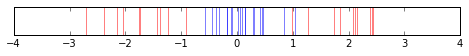

In [35]:
# Plot samples from both classes as lines on a 1D space
plt.figure(figsize=(8,0.5))
plt.xlim(-4,4)
plt.ylim(-1,1)
# Plot samples
plt.plot(x_blue, np.zeros_like(x_blue), 'b|', ms = 30) 
plt.plot(x_red_left, np.zeros_like(x_red_left), 'r|', ms = 30) 
plt.plot(x_red_right, np.zeros_like(x_red_right), 'r|', ms = 30) 
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

## Optimization by backpropagation

We will train this model by using the [backpropagation](http://en.wikipedia.org/wiki/Backpropagation) algorithm that is typically used to train neural networks. Each step in the backpropagation algorithm consists of two steps:

1. A forward propagation step to compute the output of the network.
2. A backward propagation step in which the error at the end of the network is propagated backwards through all the neurons, while updating their parameters.

### 1. Forward step

During the forward step the input will be propagated layer by layer through the network to compute the final output of the network.

The $n$ input samples with $1$ variable each are given as a $n \times 1$ matrix $X = [x_1 \ldots x_n]^T$. These inputs are projected onto the 2 dimension of the hidden layer $H$ by according to: 

$$H = \sigma(X * W_h + b_h) = \frac{1}{1+e^{-(X * W_h + b_h)}} $$

Where $W_h = [w_{h1}, w{h2}]$ the weight matrix, and 

In [25]:
# Define the logistic function
def logistic(z): return 1 / (1 + np.exp(-z))

# Weights and biases
wh = np.asmatrix([[1, 1]])
bh = np.asmatrix([[0, 0]])
wo = np.asmatrix([[1], [1]])
bo = np.asmatrix([[0]])


# Define hidden feedforward
def layer_hidden_ff(x, wh, bh):
    return logistic(x.dot(wh)+bh)

# print layer_hidden_ff(x, wh, bh)

# Define output layer feedforward
def layer_output_ff(h, wo, bo):
    return logistic(h.dot(wo) + bo)

# print layer_output_ff(layer_hidden_ff(x, wh, bh), wo, bo)

# Define the neural network function
def nn(x, wh, bh, wo, bo): 
    return layer_output_ff(layer_hidden_ff(x, wh, bh), wo, bo)

# Define the neural network prediction function that only returns
#  1 or 0 depending on the predicted class
def nn_predict(x, wh, bh, wo, bo): return np.around(nn(x, wh, bh, wo, bo))

# print nn(x, wh, bh, wo, bo)

In [26]:
# Define the cost function
def cost(y, t):
    return - np.sum(np.multiply(t, np.log(y)) + np.multiply((1-t), np.log(1-y)))

y = nn(x, wh, bh, wo, bo)
print cost(y, t)

h = layer_hidden_ff(x, wh, bh)

# print layer_output_ff(h, wo, bo)
# print t
# print h

# define the gradient function for the output layer
def gradient_output(h, wo, bo, t): 
    return (layer_output_ff(h, wo, bo) - t).T * h

go = gradient_output(h, wo, bo, t)
print go

def gradient_input(x, wh, bh, error_gradient):
    return np.sum(x * error_gradient, axis=0)

print gradient_input(x, wh, bh, go)

# define the update function delta w which returns the 
#  delta w for each weight in a vector
def delta_w(w_k, x, t, learning_rate):
    return learning_rate * gradient(w_k, x, t)

33.8232337859
[[ 5.52701646  5.52701646]]
[[-9.9041896 -9.9041896]]
